In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset overview

I will work with the Russian transcript, because... I just didn’t find any related libraries working in Kazakh that could help me in my project, unfortunately

In [4]:
dt = pd.read_csv("/content/drive/MyDrive/dataset/ml_project.csv", sep='|', dtype={10: str}, low_memory=False)

In [5]:
dt = dt[dt['talk_language'] == 'ru']
dt = dt[['idchain', 'lentime', 'comb_name', 'call_status', 'transcript_operator_words']]
dt

,idchain,lentime,comb_name,call_status,transcript_operator_words
2,01MMQUNSFK9KDFVKR0F0U2LAES05CDPU,332.0,"КАРТА, КРЕДИТНАЯ КАРТА, СОСТОЯНИЕ\ УСЛОВИЯ ПО ...",NaN,сәлеметсіз бе здравствуйте Хоум кредит банк ме...
3,01MMQUNSFK9KDFVKR0F0U2LAES05CDPU,332.0,"КАРТА, КРЕДИТНАЯ КАРТА, СОСТОЯНИЕ\ УСЛОВИЯ ПО ...",NaN,здравствуйте кредит а меня зовут Аслан чем мог...
4,01MMQUNSFK9KDFVKR0F0U2LAES05BEOQ,38.0,"ТРЕТЬЕ ЛИЦО, ИДЕНТИФИКАЦИЯ\ОТКАЗ ОТ ИНФО, ОТКА...",NaN,сәлеметсіз бе здравствуйте Хоум кредит банк ес...
5,01MMQUNSFK9KDFVKR0F0U2LAES059U9Q,165.0,"КАРТА, КРЕДИТНАЯ КАРТА, ДРУГОЕ",NaN,крюке добрый вечер хом кредит банк меня зовут ...
21,01MMQUNSFK9KDFVKR0F0U2LAES05A84D,96.0,"ПРОДУКТЫ САМООБСЛУЖИВАНИЯ, МОБИЛЬНОЕ ПРИЛОЖЕНИ...",NaN,а здравствуйте вам кредит банк меня зовут Гуль...
...,...,...,...,...,...
402083,00PPR131ESA6DCG8R0F0U2LAES03QLT5,83.0,"КРЕДИТЫ, ДЕНЕЖНЫЕ КРЕДИТЫ, ПРОДАЖА \ УСЛОВИЯ П...",NaN,сәлеметсіз бе здравствуйте Хоум кредит банк ме...
402085,00PPR131ESA6DCG8R0F0U2LAES03QLT5,83.0,"КРЕДИТЫ, ДЕНЕЖНЫЕ КРЕДИТЫ, ПРОДАЖА \ УСЛОВИЯ П...",NaN,сәлеметсіз бе здравствуйте Хоум кредит банк ме...
402088,00PPR131ESA6DCG8R0F0U2LAES040561,42.0,"КОЛЛ-БЭК, КЛИЕНТ ПРОИНФОРМИРОВАН, КЛИЕНТ ПРОИН...",NaN,сәлеметсіз бе здравствуйте Хоум кредит банк ес...
402089,00PPR131ESA6DCG8R0F0U2LAES03LGTM,101.0,"КРЕДИТЫ, ДЕНЕЖНЫЕ КРЕДИТЫ, ПРОДАЖА \ УСЛОВИЯ П...",NaN,сәлеметсіз бе здравствуйте меня зовут Гүлнар х...


# Frequency analysis

At this section I've made an analysis of frequent words that occurs in transcript. Since they are frequent, I delete them for further text processing

In [ ]:
import spacy
from collections import Counter
#I'll use joblib to better performance
from joblib import Parallel, delayed

In [ ]:
def process_text(text):
    if not isinstance(text, str):
        text = str(text)
    #this line of code loads model that trained on russian's newspapers
    nlp = spacy.load('ru_core_news_sm')
    words = nlp(text)
    filtered_words = [token.lemma_.lower() for token in words if not token.is_stop and not token.is_punct]
    return Counter(filtered_words)

In [ ]:
#this function counts frequency of words
def get_most_freq_words(transcript, num_words=20, num_cores=3):
    word_freq = Counter()
              #that's how joblib works
    results = Parallel(n_jobs=num_cores)(
        delayed(process_text)(text) for text in transcript
    )

    for result in results:
        #incrementing
        word_freq.update(result)

    return word_freq.most_common(num_words)

In [ ]:
most_common_words = get_most_freq_words(dt['transcript_operator_words'])
#by the reason of doing most part of my project locally, i'll just list most common words manually
most_common_words

most_common_words = [
    'хоум кредит банк',
    'хоум банк',
    'хом',
    'кредит банк',
    'бе',
    'сәлеметсіз',
    'день',
    'спасибо',
    'ваш',
    'здравствуйте',
    'здравствовать',
    'могу помочь',
    'мочь помочь',
    'мочь',
    'помочь',
    'звать'
]

In [ ]:
dt

# Lemmatizing

In this section, i'll lemmatize russian dt

In [ ]:
#i've used spacy lib to lemmatize my words on russina
nlp = spacy.load('ru_core_news_sm')
#dividing into tokens and collect them back into string
dt['lemmatized'] = dt['transcript_operator_words'].apply(lambda text: ' '.join([token.lemma_ for token in nlp(str(text))]))

#Reducing cardinality of comb_name

I tried several methods, including machine learning methods, but the most effective was a simple search and reduction of categories

In [ ]:
def reduce_cardinality(column):
    category_mapping = {
    'Карты': ['КАРТА', 'КРЕДИТНАЯ КАРТА', 'ДЕБЕТНАЯ КАРТА'],
    'Кредиты': ['КРЕДИТЫ', 'ДЕНЕЖНЫЕ КРЕДИТЫ', 'ПОТРЕБИТЕЛЬСКИЙ КРЕДИТ'],
    'Депозиты и счета': ['ДЕПОЗИТЫ', 'ОБЛИГАЦИИ', 'ТЕКУЩИЙ СЧЕТ'],
    'Самообслуживание и мобильные приложения': ['ПРОДУКТЫ САМООБСЛУЖИВАНИЯ', 'МОБИЛЬНОЕ ПРИЛОЖЕНИЕ'],
    'Переключения и обращения': ['ПЕРЕКЛЮЧЕНИЯ', 'ТЕЛЕМАРКЕТИНГ'],
    'Жалобы и обратная связь': ['ЖАЛОБА', 'ОБРАТНАЯ СВЯЗЬ', 'ПРЕДЛОЖЕНИЕ'],
    'Информация о банке и платежи': ['ИНФО О БАНКЕ', 'СПОСОБЫ ОПЛАТЫ', 'РЕКВИЗИТЫ'],
    'Третьи лица и прочие запросы': ['ТРЕТЬЕ ЛИЦО', 'ИДЕНТИФИКАЦИЯ', 'ДРУГОЕ', 'ХУЛИГАНСТВО']
    }

    for category, keywords in category_mapping.items():
        if any(keyword in column for keyword in keywords):
            return category

    #all other non-identified categories will be in 'Другое'
    return 'Другое'

In [ ]:
dt['new_category'] = dt['comb_name'].apply(reduce_cardinality)

#Since I've been doing biggest part of project on my local machine, to not waste time in collab, I'll just use my prepared dataset

I'll use shorted version of dataset **$6,25\%$** to reduce time training models, 'cause google collab can't give more time and power to train my model


In [1]:
import pandas as pd
import numpy as np

dt = pd.read_csv('/content/drive/MyDrive/dataset/lemmatized_sixteen.csv')
dt = dt[['lemmatized', 'new_category']]

In [2]:
#categories 2 labels
labels, uniques = pd.factorize(dt['new_category'])
dt['labels'] = labels

In [3]:
dt

,lemmatized,new_category,labels
0,сәлеметсіз бе здравствовать хоум кредит банк м...,Карты,0
1,здравствовать кредит а меня звать аслан что мо...,Карты,0
2,сәлеметсіз бе здравствовать хоум кредит банк е...,Третьи лица и прочие запросы,1
3,крюке добрый вечер хом кредит банк меня звать ...,Карты,0
4,а здравствовать вам кредит банк меня звать гул...,Самообслуживание и мобильные приложения,2
...,...,...,...
11102,здравствовать хамки тип меня звать осел что мо...,Переключения и обращения,3
11103,в день сәлеметсіз бе хоум кредит банк марина ф...,Переключения и обращения,3
11104,здравствовать хоум кредит банк меня звать асел...,Третьи лица и прочие запросы,1
11105,здравствовать хом кредит банк меня звать валер...,Третьи лица и прочие запросы,1


#Excluding stopwords


I'll use RegEx to avoid cases where the words 'кредит' and 'банк' are cut out, because they can play a key role in training the model, and cases when the text contains “хоум кредит банк” will be cut out

In [4]:
import nltk
from nltk.corpus import stopwords
import re

In [22]:
#i'll use nltk's russian stopword list and my most_common_words
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

most_common_words = [
    'хоум кредит банк',
    'хоум банк',
    'хом',
    'кредит банк',
    'бе',
    'сәлеметсіз',
    'день',
    'спасибо',
    'ваш',
    'здравствуйте',
    'здравствовать',
    'могу помочь',
    'мочь помочь',
    'мочь',
    'помочь',
    'звать'
]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
all_stopwords = set(russian_stopwords + most_common_words)

In [7]:
def remove_stopwords(text):
    pattern = r'\b(?:' + '|'.join(sorted(all_stopwords, key=len, reverse=True)) + r')\b'
    filtered_text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    filtered_text = re.sub(r'\s+', ' ', filtered_text).strip()
    return filtered_text

In [8]:
dt['lemmatized'] = dt['lemmatized'].astype(str)
dt['lemmatized'] = dt['lemmatized'].apply(remove_stopwords)

In [9]:
dt

,lemmatized,new_category,labels
0,асель мадияр барак минута соединю нужный отдел...,Карты,0
1,кредит аслан мазер маркович это звонить попаст...,Карты,0
2,есімім асел қандай көмек көрсете аламын жасалғ...,Третьи лица и прочие запросы,1
3,крюке добрый вечер курьер светлана владимирови...,Карты,0
4,гульнара гульмира етих атон вчера позвонить оф...,Самообслуживание и мобильные приложения,2
...,...,...,...
11102,хамки тип осел замера ава грин слушать иметься...,Переключения и обращения,3
11103,марина формасы че ар алар кредитный договор кр...,Переключения и обращения,3
11104,асель нужный пожалуйста повторить пожалуйста ф...,Третьи лица и прочие запросы,1
11105,валерий слушать вопрос давать проверить пожалу...,Третьи лица и прочие запросы,1


#Model training

!!! Run pip lines and restart kernel to be able to further code lines !!!

In [24]:
!pip install datasets
!pip install accelerate>=0.21.0

In [10]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
#datasets lib from hugging face is needed to run pandas' frame for model using
from datasets import Dataset

In [11]:
#splitting data into 2 parts
X_train, X_test, y_train, y_test = train_test_split(dt['lemmatized'], dt['labels'], test_size=0.1, random_state=42)

In [12]:
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test, 'label': y_test}))

In [13]:
#since they're object type, i'll do typecasting to string
train_dataset = train_dataset.map(lambda example: {"text": str(example['text'])})
test_dataset = test_dataset.map(lambda example: {"text": str(example['text'])})

Map:   0%|          | 0/9996 [00:00<?, ? examples/s]

Map:   0%|          | 0/1111 [00:00<?, ? examples/s]

In [14]:
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
#passing the number of unique categories as an argument
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(dt['new_category'].unique()))
#just in case I switch the model to cuda
model = model.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You 

In [15]:
def tokenize_function(examples):      #the first bound of BERT is max_length of tokenizer
    return tokenizer(examples['text'], max_length=512, padding='max_length', truncation=True)

#I haven't find any information how to bypass the restriction of text's size, so text will be cutted to 512 units

In [16]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

#batched=True means that function will be applied for batches, not for every unit. P - performance

Map:   0%|          | 0/9996 [00:00<?, ? examples/s]

Map:   0%|          | 0/1111 [00:00<?, ? examples/s]

In [17]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'Tesla T4')

In [19]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [21]:
trainer.train()

Step,Training Loss
10,2.245800
20,2.229300
30,2.163600
40,2.100500
50,2.017800
60,1.948000
70,1.905400
80,1.789100
90,1.866000
100,1.745000


TrainOutput(global_step=1875, training_loss=1.3138390017191568, metrics={'train_runtime': 2754.2404, 'train_samples_per_second': 10.888, 'train_steps_per_second': 0.681, 'total_flos': 7890670226976768.0, 'train_loss': 1.3138390017191568, 'epoch': 3.0})

In [23]:
results = trainer.evaluate(test_dataset)
results

{'eval_loss': 1.2352269887924194,
 'eval_runtime': 38.2671,
 'eval_samples_per_second': 29.033,
 'eval_steps_per_second': 0.915,
 'epoch': 3.0}

#Results intrepretation

The final round. I have model predictions, time to interpretations

In [26]:
from sklearn.metrics import accuracy_score

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

accuracy = accuracy_score(test_dataset['label'], predicted_labels)
accuracy

0.5922592259225923

In [32]:
dt['new_category'].unique()

array(['Карты', 'Третьи лица и прочие запросы',
       'Самообслуживание и мобильные приложения',
       'Переключения и обращения', 'Другое', 'Кредиты',
       'Депозиты и счета', 'Информация о банке и платежи',
       'Жалобы и обратная связь'], dtype=object)

In [35]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

categories = ['Карты', 'Третьи лица и прочие запросы', 'Самообслуживание и мобильные приложения',
              'Переключения и обращения', 'Другое', 'Кредиты',
              'Депозиты и счета', 'Информация о банке и платежи',
              'Жалобы и обратная связь']
encoder.fit(categories)

for category, label in zip(categories, encoder.transform(categories)):
    print(f"{category}: {label}")

Карты: 4
Третьи лица и прочие запросы: 8
Самообслуживание и мобильные приложения: 7
Переключения и обращения: 6
Другое: 1
Кредиты: 5
Депозиты и счета: 0
Информация о банке и платежи: 3
Жалобы и обратная связь: 2


In [37]:
from sklearn.metrics import classification_report
categories = [
    'Депозиты и счета',  # 0
    'Другое',            # 1
    'Жалобы и обратная связь', # 2
    'Информация о банке и платежи', # 3
    'Карты',             # 4
    'Кредиты',           # 5
    'Переключения и обращения', # 6
    'Самообслуживание и мобильные приложения', # 7
    'Третьи лица и прочие запросы' # 8
]

print(classification_report(true_labels, predicted_labels, target_names=categories))

                                         precision    recall  f1-score   support

                       Депозиты и счета       0.55      0.74      0.63       223
                                 Другое       0.50      0.49      0.49       116
                Жалобы и обратная связь       0.42      0.34      0.37        59
           Информация о банке и платежи       0.56      0.44      0.50       252
                                  Карты       0.00      0.00      0.00        62
                                Кредиты       0.69      0.83      0.76       317
               Переключения и обращения       0.72      0.72      0.72        36
Самообслуживание и мобильные приложения       0.47      0.50      0.48        28
           Третьи лица и прочие запросы       0.50      0.11      0.18        18

                               accuracy                           0.59      1111
                              macro avg       0.49      0.46      0.46      1111
                          

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


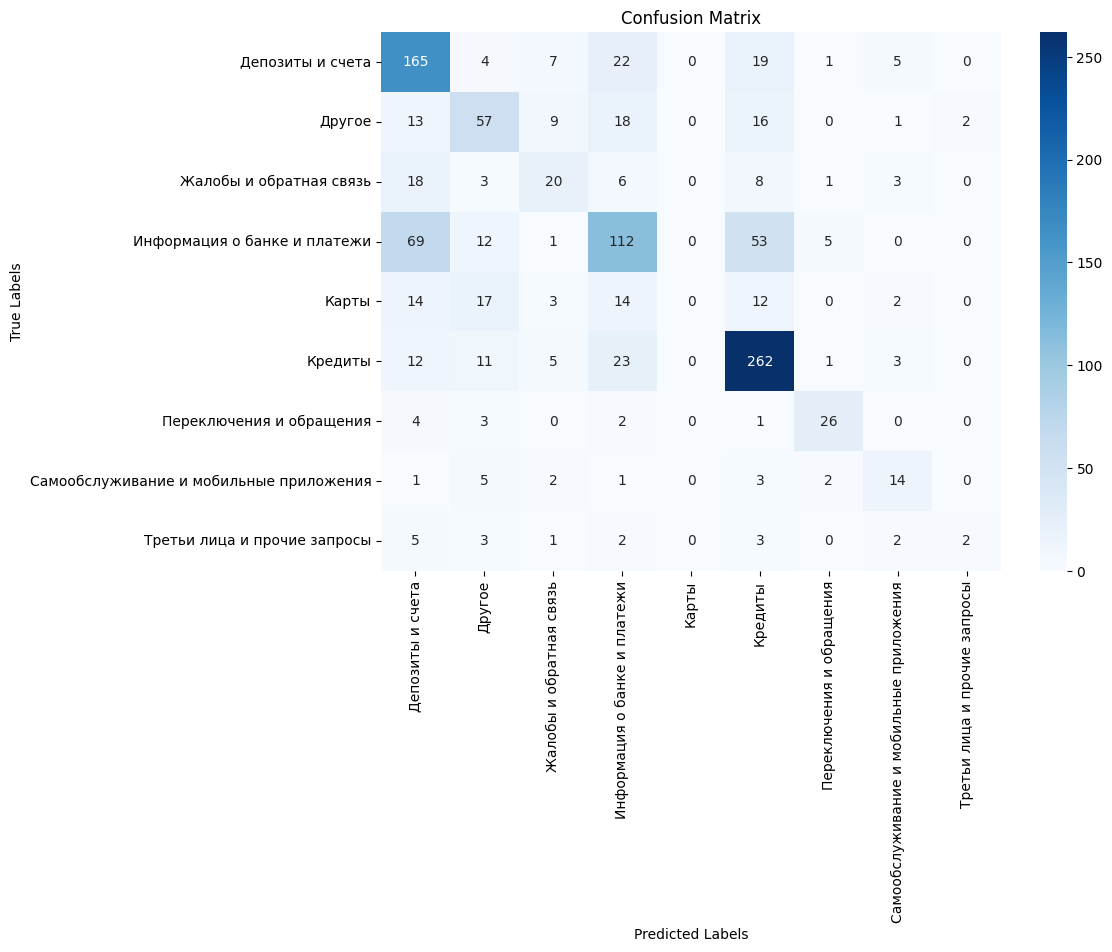

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

#**DISCLAIMER**

The model was trained on **$6.25\%$** of the total Russian-language dataset, so further results quite impressed me


#Precision

1. The best result in Precision is the category 'Переключения' and 'Кредиты'. The model predicted the results with $72\%$ and $69\%$ precisions, respectively.
2. However, the model generally predicts 'Переключения' cases well


#Recall

1. The best results in Recall were shown by 'Депозиты' ($74\%$), 'Кредиты'($83\%$) and 'Переключения' ($72\%$)

#F1-score

1. In a harmonious metric, our trio again showed good results:
'Депозиты' - $63\%$,
'Кредиты' - $76\%$,
'Переключения' - $72\%$


#Anomaly
The model predicted the 'Карты' category abnormally low - $0\%$. I can’t understand what the reason is. For the model, the words 'кодовое слово' and 'карта' could have been quite obvious category signals, but the model could not cope with this

#Overall accuracy

The overall accuracy of the model was 59%, which is quite impressive. The model works well for the most important categories for a bank (loans and deposits)

In [39]:
dt[dt['new_category'] == 'Карты']

,lemmatized,new_category,labels
0,асель мадияр барак минута соединю нужный отдел...,Карты,0
1,кредит аслан мазер маркович это звонить попаст...,Карты,0
3,крюке добрый вечер курьер светлана владимирови...,Карты,0
6,реформасы тело добрый проверить сказать машина...,Карты,0
7,ақбота минута продиктуйте пожалуйста проверить...,Карты,0
...,...,...,...
11087,разговор оператор записываться оператормен сөй...,Карты,0
11088,есім хабар сізге қандай көмегім қажет d нож ам...,Карты,0
11094,фарид кулисам канаев мамытова разговор казак о...,Карты,0
11096,амирис иги гуля азаматова пин код карта кодовы...,Карты,0


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['labels']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'labels'}, axis=1)
              .sort_values('labels', ascending=True))
  xs = counted['labels']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('labels', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('labels')
_ = plt.ylabel('count()')

In [40]:
tokenizer_save_path = "/content/drive/MyDrive/dataset/ml_project_tokenizer"
model_save_path = "/content/drive/MyDrive/dataset/ml_project_model"


model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

('/content/drive/MyDrive/dataset/ml_project_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/dataset/ml_project_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/dataset/ml_project_tokenizer/vocab.txt',
 '/content/drive/MyDrive/dataset/ml_project_tokenizer/added_tokens.json')